In [48]:
import pandas as pd
import numpy as np

# Load the Excel file
file_path = "Euler_Poles_Blocks_Result.xlsx"
xls = pd.ExcelFile(file_path)

# Store the converted data
converted_data = {}

# Process each sheet
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    
    # Ensure the required columns exist
    required_columns = ['Longitude', 'Latitude', 'Angular_velocity']
    if not all(col in df.columns for col in required_columns):
        continue  # Skip sheets that do not contain the necessary columns
    
    # Read longitude, latitude, and angular velocity
    lon = np.radians(df['Longitude'])  # Convert to radians
    lat = np.radians(df['Latitude'])  # Convert to radians
    omega = df['Angular_velocity']  # Angular velocity

    # Compute Omega_X, Omega_Y, Omega_Z (non-normalized)
    df['Omega_X'] = omega * np.cos(lat) * np.cos(lon)
    df['Omega_Y'] = omega * np.cos(lat) * np.sin(lon)
    df['Omega_Z'] = omega * np.sin(lat)

    # Compute the unit vector of the rotation axis
    norm = np.sqrt(df['Omega_X']**2 + df['Omega_Y']**2 + df['Omega_Z']**2)
    df['Rotation_Axis_X'] = df['Omega_X'] / norm
    df['Rotation_Axis_Y'] = df['Omega_Y'] / norm
    df['Rotation_Axis_Z'] = df['Omega_Z'] / norm
    df['Omega_Magnitude'] = omega  # Retain the angular velocity magnitude

    # Store the result
    converted_data[sheet_name] = df

# Save the converted data to a new Excel file
output_file = "Euler_Poles_Blocks_Result.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, df in converted_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Conversion completed, normalized results saved to {output_file}")

Conversion completed, normalized results saved to Euler_Poles_Blocks_Result.xlsx


In [49]:
import os
import pandas as pd
import numpy as np

# Define file paths
euler_pole_file = "Euler_Poles_Blocks_Result.xlsx"
boundary_files = {
    "PE": "PE_boundary.xlsx",
    "QJ": "QJ_boundary.xlsx",
    "DCS": "DCS_boundary.xlsx",
    "LJ": "LJ_boundary.xlsx",
    "ZD": "ZD_boundary.xlsx",
}

# Read Euler pole data (all sheets)
euler_poles_dict = pd.read_excel(euler_pole_file, sheet_name=None)

# Time steps (negative values represent past time, unit: million years)
time_steps = [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10]

# Define function: get column names for the corresponding sheet
def get_euler_pole_columns():
    return ["Rotation_Axis_X", "Rotation_Axis_Y", "Rotation_Axis_Z", "Angular_velocity"]

# Process Euler pole data
block_euler_pole_data = {}
for sheet, df in euler_poles_dict.items():
    required_columns = get_euler_pole_columns()

    # 确保数据包含所需列
    if all(col in df.columns for col in required_columns):
        block_euler_pole_data[sheet] = df[["Block"] + required_columns].set_index("Block").to_dict(orient="index")

# Process each boundary file
output_data = {}
for block_name, file_path in boundary_files.items():
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found, skipping {block_name}.")
        continue

    # Read boundary file (all sheets)
    block_boundaries = pd.read_excel(file_path, sheet_name=None)

    # Retain Present sheet data first
    output_sheets = {}
    if "Present" in block_boundaries:
        output_sheets["Present"] = block_boundaries["Present"]
    else:
        print(f"Warning: No 'Present' sheet in {file_path}, skipping {block_name}.")
        continue

    # Process corresponding Euler pole data
    for sheet, euler_dict in block_euler_pole_data.items():
        if block_name not in euler_dict:
            print(f"Warning: No Euler pole data for {block_name} in sheet {sheet}, skipping.")
            continue

        # Get the Euler pole parameters for the current sheet
        e_x, e_y, e_z, omega_deg_per_myr = euler_dict[block_name].values()

        # Read longitude and latitude from the Present sheet
        df_present = block_boundaries["Present"]

        # Ensure that the data contains longitude and latitude columns
        if "Longitude" not in df_present.columns or "Latitude" not in df_present.columns:
            print(f"Warning: {file_path} is missing 'Longitude' or 'Latitude' columns, skipping {block_name}.")
            continue

        # Create a DataFrame and retain original coordinates
        df_result = df_present.copy()
        df_result = df_result[["Longitude", "Latitude"]]

        # Convert longitude and latitude to radians
        longitudes = np.radians(df_present["Longitude"])
        latitudes = np.radians(df_present["Latitude"])

        # Convert angular velocity to rad/year
        omega = np.radians(omega_deg_per_myr) / 1e6  # Convert from °/Myr to rad/year

        # Compute rotated coordinates for each time step
        for time in time_steps:
            theta = omega * time * 1e6  # Compute rotation angle (radians)

            # Convert longitude and latitude to 3D Cartesian coordinates
            x = np.cos(latitudes) * np.cos(longitudes)
            y = np.cos(latitudes) * np.sin(longitudes)
            z = np.sin(latitudes)

            # Rodrigues' rotation formula (using the normalized rotation axis)
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            dot_product = e_x * x + e_y * y + e_z * z
            x_new = x * cos_theta + (e_y * z - e_z * y) * sin_theta + e_x * dot_product * (1 - cos_theta)
            y_new = y * cos_theta + (e_z * x - e_x * z) * sin_theta + e_y * dot_product * (1 - cos_theta)
            z_new = z * cos_theta + (e_x * y - e_y * x) * sin_theta + e_z * dot_product * (1 - cos_theta)

            # Convert back to longitude and latitude (degrees)
            lat_new = np.degrees(np.arcsin(z_new))
            lon_new = np.degrees(np.arctan2(y_new, x_new))

            # Store results in the DataFrame
            df_result[f"Longitude_{time}Myr"] = lon_new
            df_result[f"Latitude_{time}Myr"] = lat_new

        # Store the calculation results
        output_sheets[sheet] = df_result

    # Store the final results
    output_data[block_name] = output_sheets

# Save calculation results to Excel (one file per block, each sheet corresponds to a different time step)
output_files = {}
for block_name, sheets in output_data.items():
    output_file = f"{block_name}_boundary_Blocks_Result.xlsx"
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for sheet_name, df in sheets.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    output_files[block_name] = output_file

# Output the list of generated files
print("Calculation completed, results have been saved as follows:")
for block, path in output_files.items():
    print(f"{block}: {path}")

Calculation completed, results have been saved as follows:
PE: PE_boundary_Blocks_Result.xlsx
QJ: QJ_boundary_Blocks_Result.xlsx
DCS: DCS_boundary_Blocks_Result.xlsx
LJ: LJ_boundary_Blocks_Result.xlsx
ZD: ZD_boundary_Blocks_Result.xlsx


In [50]:
import pandas as pd

# Define file paths
file_paths = {
    "PE": "PE_boundary_Blocks_Result.xlsx",
    "QJ": "QJ_boundary_Blocks_Result.xlsx",
    "DCS": "DCS_boundary_Blocks_Result.xlsx",
    "ZD": "ZD_boundary_Blocks_Result.xlsx",
    "LJ": "LJ_boundary_Blocks_Result.xlsx"
}

# Define new sheet names
new_sheet_names = {
    "PE": "Fixed_PE",
    "QJ": "Fixed_QJ",
    "DCS": "Fixed_DCS",
    "ZD": "Fixed_ZD",
    "LJ": "Fixed_LJ"
}

# Iterate through each file, read, and update data
updated_files = {}
for key, file_path in file_paths.items():
    try:
        # Read all sheets from the Excel file
        xls = pd.ExcelFile(file_path)
        sheet_dict = {sheet: xls.parse(sheet) for sheet in xls.sheet_names}

        # Read the "Present" sheet and extract the required columns
        if "Present" in sheet_dict:
            df_present = sheet_dict["Present"]
            if {"Longitude", "Latitude"}.issubset(df_present.columns):
                # Keep only Longitude and Latitude, and rename them
                df_fixed = df_present[["Longitude", "Latitude"]].rename(
                    columns={"Longitude": "Longitude_0Myr", "Latitude": "Latitude_0Myr"}
                )
                sheet_dict[new_sheet_names[key]] = df_fixed
        
        # Save to Excel, ensuring other sheets remain unchanged
        output_file = f"{key}_boundary_Blocks_Result.xlsx"
        with pd.ExcelWriter(output_file, mode="w", engine="openpyxl") as writer:
            for sheet_name, df in sheet_dict.items():
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        updated_files[key] = output_file

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Output updated file paths
print("All files processed successfully. The Fixed_<Block> sheet has been updated with column names Longitude_0Myr and Latitude_0Myr.")
for block, path in updated_files.items():
    print(f"{block}: {path}")

All files processed successfully. The Fixed_<Block> sheet has been updated with column names Longitude_0Myr and Latitude_0Myr.
PE: PE_boundary_Blocks_Result.xlsx
QJ: QJ_boundary_Blocks_Result.xlsx
DCS: DCS_boundary_Blocks_Result.xlsx
ZD: ZD_boundary_Blocks_Result.xlsx
LJ: LJ_boundary_Blocks_Result.xlsx


In [51]:
import pandas as pd

# Define the paths of uploaded Excel files
file_paths = {
    "PE": "PE_boundary_Blocks_Result.xlsx",
    "QJ": "QJ_boundary_Blocks_Result.xlsx",
    "DCS": "DCS_boundary_Blocks_Result.xlsx",
    "LJ": "LJ_boundary_Blocks_Result.xlsx",
    "ZD": "ZD_boundary_Blocks_Result.xlsx"
}

# Create a dictionary to store boundary data
block_result_vertex_dictionary = {}

# Read all Excel files and their sheets
for block, file_path in file_paths.items():
    try:
        # Read all sheets from the Excel file
        all_sheets = pd.read_excel(file_path, sheet_name=None)  
        
        # Store all sheets in the dictionary
        block_result_vertex_dictionary[block] = all_sheets
        print(f"Successfully loaded all sheets for {block}.")
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")

# Display the structure of the loaded data
print(block_result_vertex_dictionary.keys())  # Output the loaded block names

Successfully loaded all sheets for PE.
Successfully loaded all sheets for QJ.
Successfully loaded all sheets for DCS.
Successfully loaded all sheets for LJ.
Successfully loaded all sheets for ZD.
dict_keys(['PE', 'QJ', 'DCS', 'LJ', 'ZD'])


In [52]:
import pandas as pd

# Create a new dictionary for reclassifying data
fixed_block_result_vertex_dictionary = {}

# Iterate through block_result_vertex_dictionary
for block, sheets in block_result_vertex_dictionary.items():
    for sheet_name, df in sheets.items():
        # If the sheet_name does not exist in the new dictionary, create an empty dictionary
        if sheet_name not in fixed_block_result_vertex_dictionary:
            fixed_block_result_vertex_dictionary[sheet_name] = {}
        
        # Store the block's data under the corresponding sheet_name category and rename it as PE/QJ/DCS/LJ/ZD
        fixed_block_result_vertex_dictionary[sheet_name][block] = df

# Define the output Excel file path
output_excel_path = "Fixed_block_result_data.xlsx"

# Create a new Excel Writer
with pd.ExcelWriter(output_excel_path) as writer:
    # Iterate through the categorized data
    for fixed_sheet, blocks_data in fixed_block_result_vertex_dictionary.items():
        # Create a DataFrame containing data from PE/QJ/DCS/LJ/ZD
        combined_data = {}
                
        for block, df in blocks_data.items():
            # Rename columns by adding the block name as a prefix
            renamed_columns = {col: f"{block}_{col}" for col in df.columns}
            df_renamed = df.rename(columns=renamed_columns)
            
            # Merge data
            for col, values in df_renamed.items():
                combined_data[col] = values
        
        # Convert to DataFrame and write to Excel
        final_df = pd.DataFrame(combined_data)
        final_df.to_excel(writer, sheet_name=fixed_sheet, index=False)

print(f"Data has been saved to {output_excel_path}")

Data has been saved to Fixed_block_result_data.xlsx


In [53]:
# Iterate through fixed_block_vertex_dictionary
for block, sheets in fixed_block_result_vertex_dictionary.items():
    print(f"Main Category: {block}")  # Output primary category (block name)
    for sheet_name in sheets.keys():
        print(f"  └─ Subcategory: {sheet_name}")  # Output secondary category (sheet name)

Main Category: Present
  └─ Subcategory: PE
  └─ Subcategory: QJ
  └─ Subcategory: DCS
  └─ Subcategory: LJ
  └─ Subcategory: ZD
Main Category: Fixed_DCS
  └─ Subcategory: PE
  └─ Subcategory: QJ
  └─ Subcategory: DCS
  └─ Subcategory: LJ
  └─ Subcategory: ZD
Main Category: Fixed_QJ
  └─ Subcategory: PE
  └─ Subcategory: QJ
  └─ Subcategory: DCS
  └─ Subcategory: LJ
  └─ Subcategory: ZD
Main Category: Fixed_ZD
  └─ Subcategory: PE
  └─ Subcategory: QJ
  └─ Subcategory: DCS
  └─ Subcategory: LJ
  └─ Subcategory: ZD
Main Category: Fixed_LJ
  └─ Subcategory: PE
  └─ Subcategory: QJ
  └─ Subcategory: DCS
  └─ Subcategory: LJ
  └─ Subcategory: ZD
Main Category: Fixed_PE
  └─ Subcategory: PE
  └─ Subcategory: QJ
  └─ Subcategory: DCS
  └─ Subcategory: LJ
  └─ Subcategory: ZD


Block PE is missing Latitude_-5Myr or Longitude_-5Myr, skipping this time step.


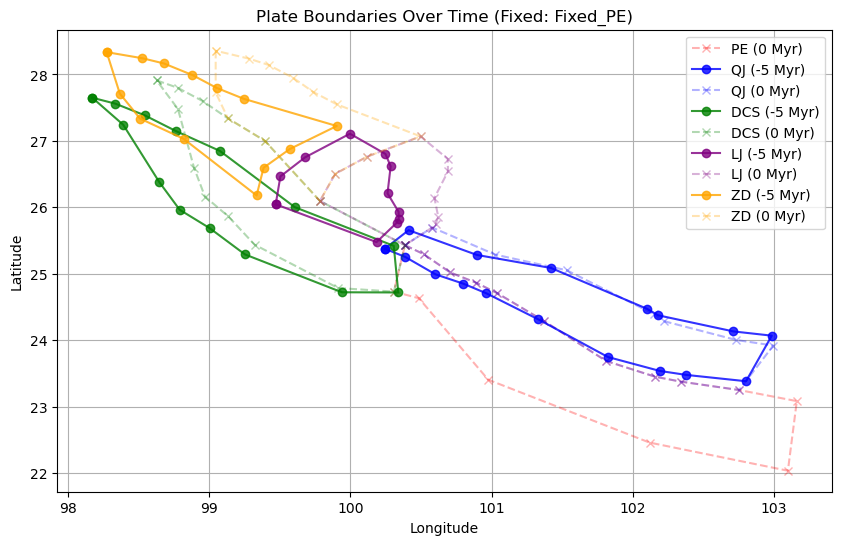

In [54]:
import matplotlib.pyplot as plt

def plot_blocks(fixed_block_result_vertex_dictionary, fixed_block, time_steps=[-1]):
    """
    Plots the boundaries of multiple blocks and shows their positions over past time steps 
    when a specific block is fixed.

    Parameters:
        fixed_block_result_vertex_dictionary (dict): Reclassified block data, where each sheet corresponds 
                                              to a fixed block, and each block contains a DataFrame.
        fixed_block (str): The name of the block used as a reference (fixed).
        time_steps (list): Time steps to plot (negative values represent past time, e.g., [-1, -2]).
    
    Returns:
        None (Displays the plot directly)
    """
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Different line styles for time steps
    markers = ['o', 'x', 's', 'd', '^']  # Different markers for time steps
    
    plt.figure(figsize=(10, 6))

    # Ensure the fixed_block exists in the dictionary
    if fixed_block not in fixed_block_result_vertex_dictionary:
        print(f"Error: Fixed block {fixed_block} does not exist.")
        return
    
    # Iterate through all related block data for the fixed block
    for idx, (block_name, df) in enumerate(fixed_block_result_vertex_dictionary[fixed_block].items()):
        # Check if required columns exist
        if "Longitude_0Myr" not in df.columns or "Latitude_0Myr" not in df.columns:
            print(f"Block {block_name} is missing 'Longitude' or 'Latitude' columns, skipping.")
            continue
        
        # Set transparency level
        alpha_value = 1.0 if block_name == fixed_block else 0.8

        # Plot past time steps
        for step_idx, t in enumerate(time_steps):
            lat_col = f"Latitude_{t}Myr"
            lon_col = f"Longitude_{t}Myr"

            if lat_col in df.columns and lon_col in df.columns:
                alpha_value = 0.3 if t == 0 else (1.0 if block_name == fixed_block else 0.8)
                plt.plot(
                    list(df[lon_col]) + [df[lon_col].iloc[0]],  # Connect first and last point
                    list(df[lat_col]) + [df[lat_col].iloc[0]],  # Connect first and last point
                    color=colors[idx % len(colors)],
                    linestyle=linestyles[step_idx % len(linestyles)],  # Different line styles for time steps
                    marker=markers[step_idx % len(markers)],  # Different markers for time steps
                    alpha=alpha_value,
                    label=f"{block_name} ({t} Myr)"
                )
            else:
                print(f"Block {block_name} is missing {lat_col} or {lon_col}, skipping this time step.") 

    # Labels, title, and legend
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Plate Boundaries Over Time (Fixed: {fixed_block})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function to display the current position and past positions at -5 Myr and 0 Myr
plot_blocks(fixed_block_result_vertex_dictionary, fixed_block="Fixed_PE", time_steps=[-5, 0])